In [1]:
# we download the findspark library and start it with findspark.init() function
import findspark
findspark.init()

In [2]:
# we create Spark context in order to work with RDD (Resilient Distributed Dataset)
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [3]:
# Spark set-up
spark=SparkSession.builder\
    .master("local[*]")\
    .appName("WordCount")\
    .getOrCreate()

In [4]:
# initialize Spark context
sc=spark.sparkContext

In [5]:
# import files (101 text files with positive reviews and 101 text files with negative reviews on Amazon movie platform)
file_positives = sc.textFile(r"C:\Users\peter\OneDrive\Документы\Личные достижения и развитие\Магистратура\Research Seminar HW2\textual dataset\data for RS\Positive")
file_negatives = sc.textFile(r"C:\Users\peter\OneDrive\Документы\Личные достижения и развитие\Магистратура\Research Seminar HW2\textual dataset\data for RS\Negative")

rdd_positives = file_positives.collect()
rdd_negatives = file_negatives.collect()

rdd_positives
rdd_negatives

["Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in.",
 "I was looking forward to this movie. Trustworthy actors, interesting plot. Great atmosphere t

In [6]:
# perform function to remove punctuation and transform all words to lowercase to achive more credible analysis
def lower_clean_str(x):
    punc='!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~-'
    lowercased_str = x.lower()
    lowercased_str = lowercased_str.replace('<br />', '')
    for ch in punc:
        lowercased_str = lowercased_str.replace(ch, '')
    return lowercased_str

In [7]:
# we transform our instances
file_positives = file_positives.map(lower_clean_str)
file_negatives = file_negatives.map(lower_clean_str)

In [8]:
# we use split function to separate the words
file_positives = file_positives.flatMap(lambda y: y.split(" "))
file_negatives = file_negatives.flatMap(lambda y: y.split(" "))

In [9]:
# exclude whitespaces from the instances
file_positives = file_positives.filter(lambda x: x!='')
file_negatives = file_negatives.filter(lambda x: x!='')

In [10]:
# to count the frequency of words we first need to apply transfrormation to (key, val) pair with the word as a key
positives_count = file_positives.map(lambda word:(word,1))
negatives_count = file_negatives.map(lambda word:(word,1))

In [11]:
# apply reduceByKey to count frequency
positives_count = positives_count.reduceByKey(lambda x,y:(x+y)).sortByKey()
negatives_count = negatives_count.reduceByKey(lambda x,y:(x+y)).sortByKey()

In [12]:
# we need to switch the key and value to sort by the number of words
positives_count = positives_count.map(lambda x:(x[1],x[0]))
negatives_count = negatives_count.map(lambda x:(x[1],x[0]))

negatives_count.sortByKey(False)
positives_count.sortByKey(False)

PythonRDD[36] at RDD at PythonRDD.scala:53

In [13]:
# we also need to exclude stopwords to make our analysis brighter
# to exclude stopwords words, we download the nltk library and get the list of English stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\peter\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# we exclude stopwords values
positives_count = positives_count.filter(lambda x: x[1] not in stopwords).sortByKey(False)
negatives_count = negatives_count.filter(lambda x: x[1] not in stopwords).sortByKey(False)

In [15]:
#display the result for positive datasets
positives_count.sortByKey(False).take(10)

[(139, 'movie'),
 (130, 'film'),
 (113, 'one'),
 (63, 'see'),
 (58, 'good'),
 (54, 'even'),
 (49, 'great'),
 (46, 'time'),
 (44, 'like'),
 (44, 'show')]

In [16]:
#display the result for negative datasets
negatives_count.sortByKey(False).take(10)

[(177, 'film'),
 (136, 'movie'),
 (117, 'one'),
 (77, 'like'),
 (65, 'even'),
 (64, 'horror'),
 (55, 'good'),
 (51, 'bad'),
 (51, 'really'),
 (50, 'get')]

In [17]:
from pyspark.sql.types import *
schema = StructType([StructField("frequency", IntegerType(), True),
                     StructField("word", StringType(), True)])

In [18]:
counts_df_positives = spark.createDataFrame(positives_count, schema)
counts_df_negatives = spark.createDataFrame(negatives_count, schema)

In [19]:
counts_df_positives.printSchema()
counts_df_negatives.printSchema()

root
 |-- frequency: integer (nullable = true)
 |-- word: string (nullable = true)

root
 |-- frequency: integer (nullable = true)
 |-- word: string (nullable = true)



In [20]:
df_positives = counts_df_positives.toPandas()
df_negatives = counts_df_negatives.toPandas()

In [21]:
df_positives

,frequency,word
0,139,movie
1,130,film
2,113,one
3,63,see
4,58,good
...,...,...
3873,1,yells
3874,1,yoyo
3875,1,yuppie
3876,1,zandt


In [22]:
df_negatives

,frequency,word
0,177,film
1,136,movie
2,117,one
3,77,like
4,65,even
...,...,...
4945,1,zombielikeand
4946,1,zorro
4947,1,zudina
4948,1,£199


In [23]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [167]:
from wordcloud import WordCloud

frequencies_positives = df_positives.set_index('word').T.to_dict('records')
frequencies_negatives = df_negatives.set_index('word').T.to_dict('records')

wc_negatives = WordCloud(background_color="white", max_words=5000)
wc_negatives.generate_from_frequencies(dict(*frequencies_negatives))

wc_positives = WordCloud(background_color="white", max_words=5000)
wc_positives.generate_from_frequencies(dict(*frequencies_positives))

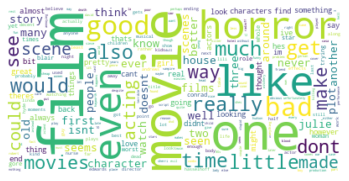

In [168]:
plt.imshow(wc_negatives, interpolation='bilinear')
plt.axis("off")
plt.show()

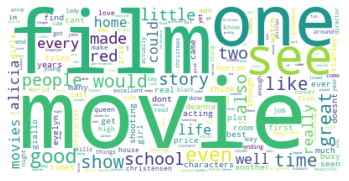

In [169]:
plt.imshow(wc_positives, interpolation='bilinear')
plt.axis("off")
plt.show()

In [112]:
import os, glob
import pandas as pd
import csv

# Define relative path to folder containing the text files

files_folder = r"C:\Users\peter\OneDrive\Документы\Личные достижения и развитие\Магистратура\Research Seminar HW2\textual dataset\data for RS\All"
files = []

# Create a dataframe list by using a list comprehension

files = [pd.read_csv(file, quoting=csv.QUOTE_NONE, header=None, sep = r'\t') for file in glob.glob(os.path.join(files_folder ,"*.txt"))]

# Concatenate the list of DataFrames into one
files_df = pd.concat(files)

In [114]:
files_df

,0
0,Once again Mr. Costner has dragged out a movie...
0,Bromwell High is a cartoon comedy. It ran at t...
0,I was looking forward to this movie. Trustwort...
0,Scott Bartlett's 'OffOn' is nine minutes of pu...
0,I gave this a 3 out of a possible 10 stars.<br...
...,...
0,"For me too, this Christmas special is one that..."
0,Four things intrigued me as to this film - fir...
0,A Christmas Together actually came before my t...
0,David Bryce's comments nearby are exceptionall...


In [117]:
files_df.rename(columns = {0 : 'Review'}, inplace = True)

In [118]:
files_df

,Review
0,Once again Mr. Costner has dragged out a movie...
0,Bromwell High is a cartoon comedy. It ran at t...
0,I was looking forward to this movie. Trustwort...
0,Scott Bartlett's 'OffOn' is nine minutes of pu...
0,I gave this a 3 out of a possible 10 stars.<br...
...,...
0,"For me too, this Christmas special is one that..."
0,Four things intrigued me as to this film - fir...
0,A Christmas Together actually came before my t...
0,David Bryce's comments nearby are exceptionall...


In [125]:
from textblob import TextBlob

def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText
files_df['Review'] = preprocess(files_df['Review'])

files_df['polarity'] = files_df['Review'].map(lambda text: TextBlob(text).sentiment.polarity)
files_df['review_len'] = files_df['Review'].astype(str).apply(len)
files_df['word_count'] = files_df['Review'].apply(lambda x: len(str(x).split()))

C:\Users\peter\AppData\Local\Temp/ipykernel_3532/2275854709.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  ReviewText = ReviewText.str.replace("(<br/>)", "")
C:\Users\peter\AppData\Local\Temp/ipykernel_3532/2275854709.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
C:\Users\peter\AppData\Local\Temp/ipykernel_3532/2275854709.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  ReviewText = ReviewText.str.replace('(&amp)', '')
C:\Users\peter\AppData\Local\Temp/ipykernel_3532/2275854709.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  ReviewText = ReviewText.str.replace('(&gt)', '')
C:\Users\peter\AppData\Local\Temp/ipykernel_3532/2275854709.py:8: FutureWarning: The default value of regex will change from True to False in

In [128]:
files_df

,Review,polarity,review_len,word_count
0,Once again Mr. Costner has dragged out a movie...,0.063860,900,168
0,Bromwell High is a cartoon comedy. It ran at t...,0.086675,806,140
0,I was looking forward to this movie. Trustwort...,0.158069,1179,215
0,Scott Bartlett's 'OffOn' is nine minutes of pu...,0.115540,2209,337
0,I gave this a 3 out of a possible 10 stars.<br...,-0.090278,1316,232
...,...,...,...,...
0,"For me too, this Christmas special is one that...",0.368407,638,118
0,Four things intrigued me as to this film - fir...,0.106221,749,126
0,A Christmas Together actually came before my t...,0.118069,975,176
0,David Bryce's comments nearby are exceptionall...,0.080296,2284,388


In [143]:
print('5 random reviews with the highest positive sentiment polarity: \n')
cl = files_df.loc[files_df.polarity > 0.4, ['Review']].sample(5).values
for c in cl:
    print(c[0], '\n')

5 random reviews with the highest positive sentiment polarity: 

The great Vincent Price has done many fantastic Horror films, some of which range among the greatest genre gems of all-time. Price's greatest achievements were doubtlessly his films in the 60s, with films such as Roger Corman's brilliant Poe-cycle (still the greatest Horror cycle of all-time), Michael Reeves' "Witchfinder General" (1968) or Ubaldo Ragona's "The Last Man on Earth" (1964) marking the ultimate highlights of this brilliant man's career. The films that made the man famous and thereby made him the immortal Horror icon he is, however date back to the 50s, with "House of Wax" (1953) marking his rise to stardom. "The Mad Magician" of 1954 follows a plot that is very similar to that of its successful predecessor. This is not to say, however, that this film isn't an original, delightfully macabre and absolutely wonderful gem itself. As the lines above may suggest, Vincent Price is my favorite actor, and, while I per

In [142]:
print('5 random reviews with the highest negative sentiment polarity: \n')
cl = files_df.loc[files_df.polarity < -0.2, ['Review']].sample(5).values
for c in cl:
    print(c[0], '\n')

5 random reviews with the highest negative sentiment polarity: 

Seriously, I can't imagine how anyone could find a single flattering thing to say about this movie, much less find it in themselves to write the glowing compliments contained in this comment section. How many methamphetamines was Bogdonovitch on during the filming of this movie? Was he giving a bonus to the actor that spat his lines out with the most speed and least inflection or thought? The dialogue is bad, the plot atrocious, even for a "screwball" comedy, and claims that the movie is an homage to classic film comedy is about the most inane thing I've ever heard. The cinematography is below the quality and innovation of that exhibited by the worst made-for-TV movies, the acting is awful (although I get the feeling that the fault for that lies squarely in the lap of the director), and speaking of which, did I mention the direction is so haphazard and inscrutable that it defies the definition of the word? The whole thing

In [146]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [147]:
files_df['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

In [149]:
files_df['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

In [150]:
files_df['word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Review Text Word Count Distribution')

In [157]:
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(["br"])

In [159]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(files_df['Review'], 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df4.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after removing stop words')


ve seen 21
red queen 19
home room 18
vincent price 18
erika christensen 14
linda blair 13
don know 12
school shooting 12
horror movie 11
busy phillips 11
la casa 10
house wax 10
jane fonda 9
stanley iris 9
high school 9
horror film 9
low budget 9
special effects 9
queen kills 9
kills seven 9


In [160]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(files_df['Review'], 20)
for word, freq in common_words:
    print(word, freq)
df6 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df6.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review after removing stop words')

red queen kills 9
kills seven times 7
queen kills seven 6
night evelyn came 6
evelyn came grave 6
jane fonda robert 4
don know going 3
fonda robert niro 3
la dama rossa 3
queen kills times 3
anti social goth 3
tommy michael manchester 3
jerry rick farnsworth 3
lydia reed hassie 3
michael winkelman little 3
winkelman little luke 3
merging film video 2
thoroughly bored looking 2
inspired andrews edwards 2
doesn make sense 2
